[View in Colaboratory](https://colab.research.google.com/github/SubmitCode/fifa_prediction/blob/master/fifa_prediction_part02.ipynb)

# Part 2: Estimator


# Summary
Wie versprochen geht's jetzt ans eingemachte. Was besonders interessant ist, dass meine Ergebnisse teilweise start von den [Wetten bei Oddschecker](https://www.oddschecker.com/football/world-cup/winner) abweichen. Bitte berücksichtigen, dass es sich hier um einen Showcase handelt. Also bitte die Ergebnisse mit Vorsicht geniessen.  

Was mir besonders aufgefallen ist, laut meiner Statistik ist ....
- Schweiz wird gegen Deutschland antreten 
- Dänemark kann sehr weit kommen.
- Argentinien wird früh Ausscheiden. 

Wer gleich zum Ergebnis will bitte einfach runter Scrollen.


Besonders möchte ich [Dr. James Bond](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner) danken. Sein Code diente in vielen Teilen als Inspiration.




# Data
- __FIFA Soccer Rankings__ Infos über die Rankingmehthode findet ihr [hier](https://en.wikipedia.org/wiki/FIFA_World_Rankings). Diese Daten wurden von der [Tadhg Fitzgerald](https://www.kaggle.com/tadhgfitzgerald/fifa-international-soccer-mens-ranking-1993now) extrahiert. 
- __FIFA World Cup__ [Andre Becklas](https://www.kaggle.com/abecklas/fifa-world-cup/data) hat folgende 3 Dateien bereitgestellt
  - WorldCupMatches.csv alle WM Matches seit 1930
  - WorldCupPlayers.csv alle WM Spieler 
  - WorldCups.csv. Zusammenfassung aller Fussball WM's
- __International football results from 1872 to 2018__ [Mart Jürisoo
](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017/data) hat die Daten freundlicherweise zu Verfügung gestellt. 
  - results.csv
  
  Special thanks to  [Dr. James Bond](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner). Ich werde seine Codes teilweise übernehmen und ggf. anpassen.
  
  
  
 

# Vorgehen
Grundsätzlich nehmen wir alle unsere Länderspiele und versuchen anhand des Ranges, Punkte etc. vorherzusagen welche Mannschaft gewinnen wird. 
Data Science besteht zu 80% Data preparation. Deshalb gehen wir folgendermassen vor:
- __Setup:__ Downlaod der Daten 
- __Data preparation__ 
- __Feature engineering:__
- __create model:__ hierbei werden wir mit einer einfachen logistischen Regression beginnen. Keine Angst [logistische Regression](https://en.wikipedia.org/wiki/Logistic_regression) bedeutet nichts anderes als, dass das Ergebnis unserer Gleichung entweder 0 oder 1 ist. Dadurch kann das Ergebniss auch als Wahrscheinlichkeit betrachtet werden. Logistische Regression eignet sich vor allem weil auch bei den Fussballspielen nur 2 mögliche Outcomes gibt (na gut es gibt drei, wenn wir Unentschieden mit berücksichtigen).
- __Modelierung__
- __Simulation__

## Setup

In [0]:
# import von den libraries die wir für die Berechnungen und Visualisierungen 
# benötigen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path

In [0]:
'''
Downlaod the data from my Github page
'''

link_src = "https://github.com/SubmitCode/fifa_prediction/raw/master/data/"

# rankings
linkSoccerRankings = "FIFASoccerRankings/fifa_ranking.csv" 
data_ranking = pd.read_csv(os.path.join(link_src,linkSoccerRankings))


# international football results
linkinterantionalFootballResults = "internationalFootballResults/interantionalFootballResults.csv" 
data_interantionalFootballResults = pd.read_csv(os.path.join(link_src,linkinterantionalFootballResults))


# fifa world cup 2018
linkWorldCup2018 = "fifaWorldCup2018/WorldCup2018.csv" 
data_WorldCup2018 = pd.read_csv(os.path.join(link_src,linkWorldCup2018))


## Data preparation

Im folgenden Teil werden wir die Ländernamen an den Standard anpassen, sodass wir die Daten miteinander verknüpfen können. 

In [0]:
# dieser Code braucht relative lange zum Ausführen. Deshalb ist jetzt Zeit für 
# einen Kaffee :-)


# hier nehmen wir die notwendigen columns raus und ignorieren die anderen 
rankings = data_ranking.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']] 


rankings = rankings.replace({"IR Iran": "Iran"})# wir benennen Iran um damit dieses Land dem Standardt entspricht
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] \
    + rankings['two_year_ago_weighted']\
    + rankings['three_year_ago_weighted'] # die summe von drei Durchschnitten, dadurch sollte das Ergebnis robuster sein
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])


matches =  data_interantionalFootballResults.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = data_WorldCup2018.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team') # dadurch finden wir die richtige Zeile anhand des Teams


## Feature engineering


In [0]:
# hier erweitern wir die Rankingstabelle sodass wir jeden Tag einen Eintrag haben
# dies ist insofern wicht, da das rank_date und das date von den matches nicht
# übereinstimmen. Um die beiden Tabellen zu vereinigen, erweitern wir die 
# rankings Tabelle, sodass wir jeden Tag einen Eintrag haben. Wenn an einem Tag
# kein Wert vorhanden ist, nehmen wir den Wert vom Vortag (fill forward)
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# jetzt joinen wir die matches mit den rankings von dem jeweiligen Team 
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))



In [5]:

t_rankings = rankings
print(matches.tail())
print(matches.columns)

            date       home_team    away_team  home_score  away_score  \
18474 2018-06-07         Uruguay   Uzbekistan           3           0   
18475 2018-06-07        Portugal      Algeria           3           0   
18476 2018-06-07  Korea Republic      Bolivia           0           0   
18477 2018-06-07         Iceland        Ghana           2           2   
18478 2018-06-07           India  New Zealand           1           2   

      tournament        city   country  neutral rank_date_home  \
18474   Friendly  Montevideo   Uruguay    False     2018-06-07   
18475   Friendly      Lisbon  Portugal    False     2018-06-07   
18476   Friendly   Innsbruck   Austria     True     2018-06-07   
18477   Friendly   Reykjavík   Iceland    False     2018-06-07   
18478   Friendly      Mumbai     India    False     2018-06-07   

              ...           three_year_ago_weighted_home weighted_points_home  \
18474         ...                                 119.85               774.57   
18

In [0]:
# nun definieren wir die Features
# - rank_difference=RangManschaftMitHeimvorteil - RangMannschaftOhneHeimvorteil
# - point_difference=PunkteMannschatMitHeimvorteil - PunkteMannschaftOhneHeimvorteil
# - score_difference ist der Torunterschied
# - is_won: gewonnen hat die Mannschaft mit einem positiven Torunterschied
# - is_stake: True wenn es sich um ein Freundschaftspiel handelt
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'



In [7]:
matches.loc[0:5,['home_team', 'away_team', \
                  'weighted_points_home', 'weighted_points_away', 'point_difference',\
                  'rank_home', 'rank_away', 'rank_difference', \
                  'home_score', 'away_score', 'score_difference', \
                  'tournament', 'is_stake']]

,home_team,away_team,weighted_points_home,weighted_points_away,point_difference,rank_home,rank_away,rank_difference,home_score,away_score,score_difference,tournament,is_stake
0,Bolivia,Uruguay,0.0,0.0,0.0,59.0,22.0,37.0,3,1,2,FIFA World Cup qualification,True
1,Brazil,Mexico,0.0,0.0,0.0,8.0,14.0,-6.0,1,1,0,Friendly,False
2,Ecuador,Venezuela,0.0,0.0,0.0,35.0,94.0,-59.0,5,0,5,FIFA World Cup qualification,True
3,Guinea,Sierra Leone,0.0,0.0,0.0,65.0,86.0,-21.0,1,0,1,Friendly,False
4,Paraguay,Argentina,0.0,0.0,0.0,67.0,5.0,62.0,1,3,-2,FIFA World Cup qualification,True
5,Peru,Colombia,0.0,0.0,0.0,70.0,19.0,51.0,0,1,-1,FIFA World Cup qualification,True


## Modeling

Jetzt geht's wirklich ans eingemachte :-). Nun versuchen wir mit der sehr bekannten [scikit-learn](http://scikit-learn.org/stable/index.html) eine einfaches Model zu bauen.

Vielleicht ein paar wichtige Punkte. Bei einfachen ML Modellen ist es immer sehr wichtig die Regression niemals auf die gesamten Daten zu fitten. Deshalb nehmen wir in diesem Fall einen Train-Test Split von 0.2. Das Model bekommt 80% der Daten. Die Qualität des Modelles wird allerdings anhander der 20% gemessen, welches das Model noch nicht gesehen hat.

$X$ steht für die unabhängigen Variablen (unsere Features)
$y$ sind die labels also die abhängige Variable (in unserem Fall $1$ wenn das Spiel gewonnen wurde und $0$ wenn das Spiel verloren wurde).

[Hier](https://www.coursera.org/learn/machine-learning/lecture/Rqgfz/features-and-polynomial-regression) noch ein interessantes Video welches Polynomial Features erklärt. Der $C$ Parameter in der LogisticRegression regelt die sogenannte Regularization. [Hier](https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul) findet ihr ein Beschreibung.

In [0]:
import itertools
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


X, y = matches.loc[:,['rank_home', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

Mit unserem einfachen Model erzielen wir eine Trefferquote von 68.2%.
Confusion matrix, without normalization
[[1311  597]
 [ 577 1211]]
Normalized confusion matrix
[[0.69 0.31]
 [0.32 0.68]]


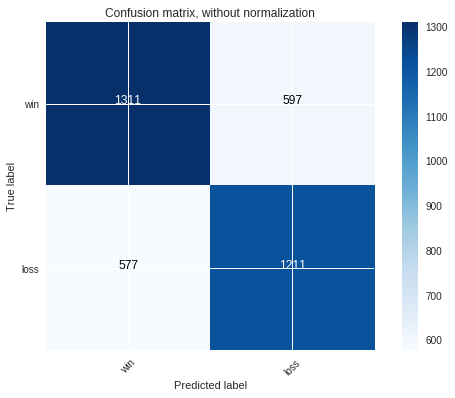

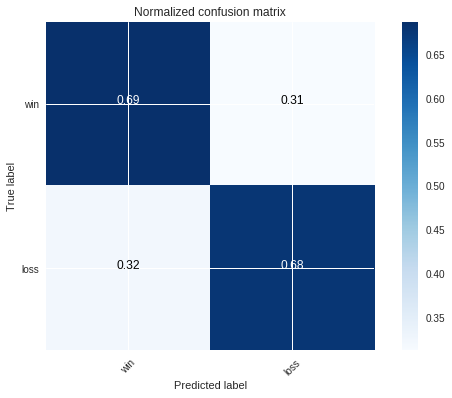

In [9]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, model.predict(X_test))
print("Mit unserem einfachen Model erzielen wir eine Trefferquote von {}%."\
      .format(round(accuracy,3)*100))
model.get_params('logistic_regression')
y_pred = model.predict(X_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    from sci-kit learn website
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
class_names = ["win","loss"]
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Oben sehen wir ein sogennante Confusin Matrix. Die zeigt sehr schön an in wieviel % der Fälle wir richtig waren. Z.B. in 71% der Fälle prognostizierten wir die Gewinner Mannschaft, die auch tatsächlich gewonnen haben. Hingegen lagen wir bei den Verlierern nur in 65% der Fälle richtig.

## Simulation
Nun werden wir anhand der Gruppenspiele eine Simulation erstellen. 

In [0]:
# hier definieren wir eine margin wenn das Ergebnis kanpp wird dann gehen wir von einem
# Unentschieden aus
margin = 0.01

# hier wählen wir die aktuellen Rankings aus der Tabelle
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])


In [11]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        row['rank_home'] = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['rank_difference'] = row['rank_home'] - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group B:___
Portugal vs. Spain: Portugal wins with 0.54
Portugal vs. Morocco: Portugal wins with 0.68
Portugal vs. Iran: Portugal wins with 0.66
Spain vs. Morocco: Spain wins with 0.65
Spain vs. Iran: Spain wins with 0.63
Morocco vs. Iran: Iran wins with 0.55
___Starting group A:___
Russia vs. Saudi Arabia: Saudi Arabia wins with 0.55
Russia vs. Egypt: Egypt wins with 0.66
Russia vs. Uruguay: Uruguay wins with 0.83
Saudi Arabia vs. Egypt: Egypt wins with 0.65
Saudi Arabia vs. Uruguay: Uruguay wins with 0.83
Egypt vs. Uruguay: Uruguay wins with 0.74
___Starting group E:___
Brazil vs. Switzerland: Brazil wins with 0.53
Brazil vs. Costa Rica: Brazil wins with 0.62
Brazil vs. Serbia: Brazil wins with 0.67
Switzerland vs. Costa Rica: Switzerland wins with 0.59
Switzerland vs. Serbia: Switzerland wins with 0.64
Costa Rica vs. Serbia: Costa Rica wins with 0.54
___Starting group D:___
Argentina vs. Iceland: Argentina wins with 0.60
Argentina vs. Croatia: Argentina wins with 0.59
Ar

In [12]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        row['rank_home'] = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['rank_difference'] = row['rank_home'] - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.54
Denmark vs. Croatia: Denmark wins with probability 0.55
Brazil vs. Mexico: Brazil wins with probability 0.58
Belgium vs. Colombia: Belgium wins with probability 0.59
Egypt vs. Portugal: Portugal wins with probability 0.81
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.60
England vs. Poland: Poland wins with probability 0.53


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.51
Brazil vs. Belgium: Belgium wins with probability 0.51
Portugal vs. Argentina: Portugal wins with probability 0.51
Germany vs. Poland: Germany wins with probability 0.57


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.57
Portugal vs. Germany: Germany wins with probability 0.56


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.54




In [13]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

Selecting previously unselected package fontconfig.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../01-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5ubuntu0.1_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5ubuntu0.1) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6.0-3_amd64.deb ...
Unpa

Unpacking graphviz (2.38.0-16ubuntu2) ...
Setting up libpathplan4 (2.38.0-16ubuntu2) ...
Setting up libxcb-render0:amd64 (1.12-1ubuntu1) ...
Setting up libjbig0:amd64 (2.1-3.1) ...
Setting up libdatrie1:amd64 (0.2.10-5) ...
Setting up libtiff5:amd64 (4.0.8-5ubuntu0.1) ...
Setting up libgraphite2-3:amd64 (1.3.10-2) ...
Setting up libpixman-1-0:amd64 (0.34.0-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up libltdl7:amd64 (2.4.6-2) ...
Setting up libxcb-shm0:amd64 (1.12-1ubuntu1) ...
Setting up libxpm4:amd64 (1:3.5.12-1) ...
Setting up libxt6:amd64 (1:1.1.5-1) ...
Setting up libthai-data (0.1.26-3) ...
Setting up libcdt5 (2.38.0-16ubuntu2) ...
Setting up fontconfig (2.11.94-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libcgraph6 (2.38.0-16ubuntu2) ...
Setting up libwebp6:amd64 (0.6.0-3) ...
Setting up libcairo2:amd64 (1.14.10-1ubuntu1) ...
Setting up libgvpr2 (2.38.0-16ubuntu2) ...
Setting up libgd3:amd64 (2.2.5-3) ...
Setting up libharfbuzz0b:amd64 (

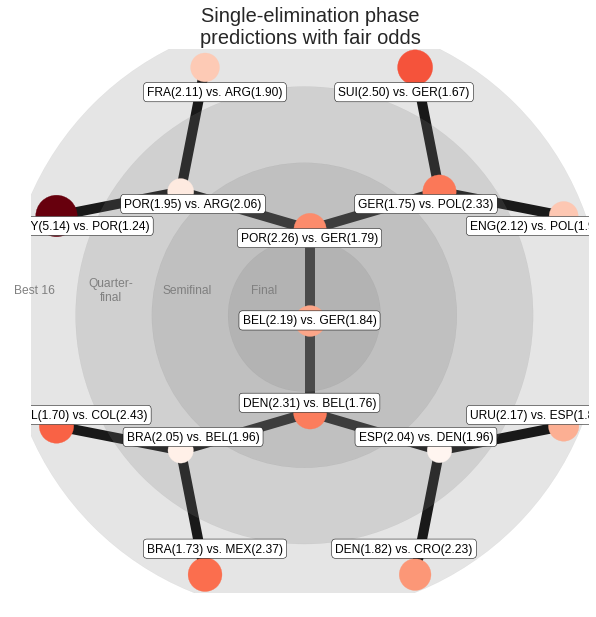

In [14]:
# diese Grafik habe ich von https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner übernommen

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi', args='')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()

# Zusammenfassung

Dies ist ein gutes Beispiel, wie man mit einfachen Mitteln (Regression) schon relative gute Ergebnisse bekommen kann. Zumindest deutlich besser als der Zufall. 

Auf der [Odd Checker Seite](https://www.oddschecker.com/football/world-cup/winner) könnten wir nun vergleichen wie die Meinung ist im Vergleich zu unserem Model.

Wer ein bisschen Zeit hat könnte...

- die Features normalisieren um zu sehen ob dies einen Einfluss hat
- [Cross Validation](http://scikit-learn.org/stable/modules/cross_validation.html) implentieren 
- zusätzliche Features ableiten

Wenn die Zeit reicht werde ich versuchen noch zusätzliche Daten aufzutreiben.